In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import math
import copy
import os
import spatialmath as sm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import pkg_resources
pkg_resources.get_distribution("open3d").version

'0.16.0'

In [2]:
depthImage = copy.deepcopy(np.load("depth_image.npy"))
segImage = copy.deepcopy(np.load("seg_image.npy"))
regImage = copy.deepcopy(np.load("reg_image.npy"))

In [3]:
class Block():
    def __init__(self,name,pcd):
        self.blockPCD = pcd
        self.name = name
        # Removes outlier points by fitting block into largest cluster
        self.clusterBlockPCD()
        self.blockAABB = self.blockPCD.get_axis_aligned_bounding_box()
        self.blockOBB = self.blockPCD.get_oriented_bounding_box()
        self.urPose = np.eye(4) # Pose of the Nth frame of the UR5 when the image was taken
        self.camFrameCoords = np.matrix(self.blockOBB.get_center()[0:3])
        self.gripperFrameCoords = self.getCenterInGripperFrame()
        self.worldFrameCoords = self.getCenterInWorld() # Approximate coordinates in world frame 
        
    def clusterBlockPCD(self):
        # modifies block PCD to only contain points in the largest cluster found with DBScan
        # eps found experimentally
        with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Error) as cm:
                # eps is radius
                # rejects points that are too small
                labels = np.array(self.blockPCD.cluster_dbscan(eps=0.013, min_points=20, print_progress=False))

        max_label = labels.max()
        colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        colors[labels < 0] = 0
        clusters = {}
        for i in range(0,max_label + 1):
            clusters[i] = []

        for i in range(0,len(labels)):
            if labels[i] != -1:
                clusters[labels[i]].append(i)

        clusterPCDs = []
        for clusterLabel in clusters:
            clusterPCD = self.blockPCD.select_by_index(clusters[clusterLabel])
            clusterPCDs.append(clusterPCD)
        self.blockPCD = clusterPCDs[0]
    
    
    def getCenterInGripperFrame(self):
        # returns the center of the block in the gripper frame given PCD with no extrinsics applied
        R = np.array([[0,1,0],[-1,0,0],[0,0,1]]) # camera frame basis with respect to gripper frame
        t = np.array([0,9,59.3]) / 1000  # camera frame origin with respect to gripper frame (mm)
        # Homogenous coordinates         
        # gripperFrameCoords = np.matmul(np.array(sm.SE3.Rt(R,t)),self.cameraFrameCoords[0:3])
        gripperFrameCoords = (sm.SE3.Rt(R,t) * sm.SE3.Trans(self.camFrameCoords[0:3])).t
        '''
        # For visualization in displayPCD
        self.real.cameraFrameTransform = np.array(camera_frame_transform)
        print(f"Camera Frame Transform:\n{self.real.cameraFrameTransform}")
        self.real.extrinsics = np.array(camera_frame_transform.inv())
        print(f"Extrinsics:\n{self.real.extrinsics}")
        '''
        
        return gripperFrameCoords

    def getCenterInWorld(self):
        # Uses pose of the Nth frame from UR5 Interface to return the approximate center of the block in the world frame
        # may be wrong due to innacurate measurements of end-effector tool dimensions
        # CHANGE CURRENT POSE WHEN CONNECTED TO BOT
        # Pose of Nth frame of UR5 
        # currentPose = self.ur.getPose() #SE3 Object
        currentPose = sm.SE3.Rt(np.array([[0,-1,0],[0,0,1],[-1,0,0]]),np.array([0,1,0]))
        # d should probably be a 3D translation but this is for testing
        d = 0.1125 # estimated distance between end-effector frame origin and center of gripper frame along z-axis (m)
        gripperFramePose = currentPose * sm.SE3.Tz(d)
        worldFrameCoords = (gripperFramePose * sm.SE3.Trans(self.gripperFrameCoords)).t
        return worldFrameCoords
   
    def getGraspPoint(self):
        # returns the (x,y,z) coordinates in either the world or camera coordinate frame of where the gripper should be placed (depending on if extrinsics were set when creating the PCD)
        # center of front-facing axis-aligned bounding box
        x,y,z = self.blockAABB.get_center()[0:3]
        # z = self.blockAABB.get_min_bound()[2]        
        return (x,y,z)
    
    def move(self,goalCamCoords):
        self.currentCamCoords = goalCamCoords


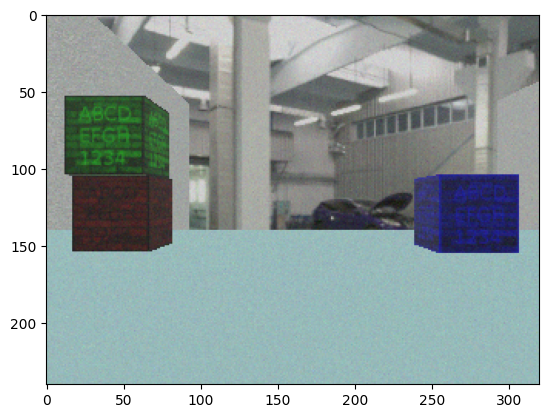

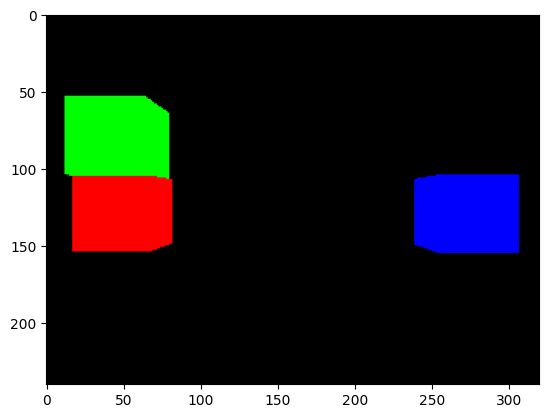

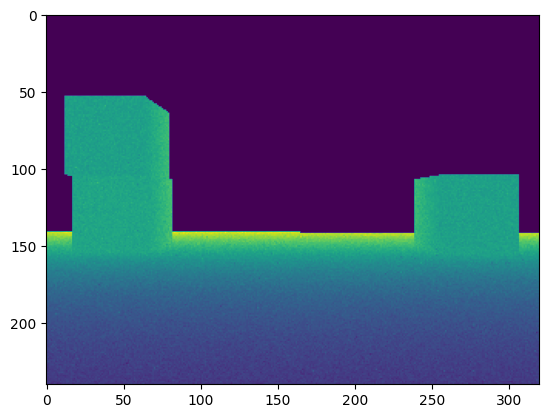

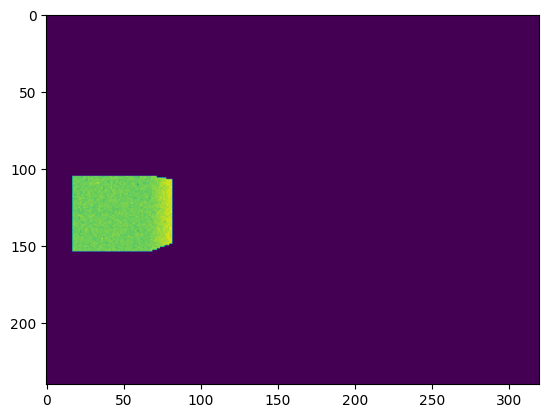

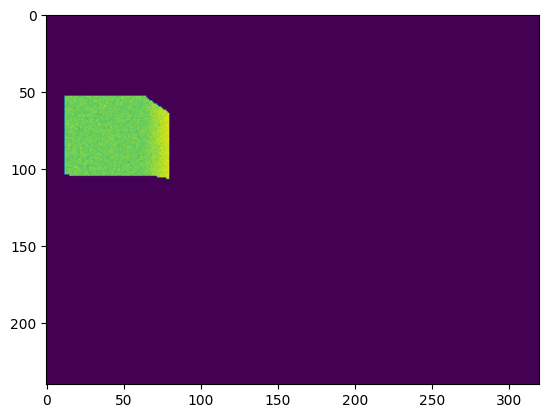

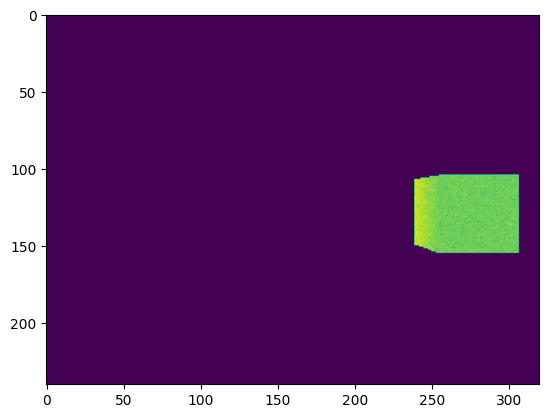

redBlock:
CamFrameCoords: [[-0.21333445  0.02296053  0.63104511]]
GripperFrameCoords: [0.02296053 0.22233445 0.69034511]
WorldFrameCoords: [-0.22233445  1.80284511 -0.02296053]
yellowBlock:
CamFrameCoords: [[-0.21121486 -0.1033662   0.62994143]]
GripperFrameCoords: [-0.1033662   0.22021486  0.68924143]
WorldFrameCoords: [-0.22021486  1.80174143  0.1033662 ]
blueBlock:
CamFrameCoords: [[0.20376852 0.01849358 0.62646594]]
GripperFrameCoords: [ 0.01849358 -0.19476852  0.68576594]
WorldFrameCoords: [ 0.19476852  1.79826594 -0.01849358]


In [4]:
def showImages(images):
    for image in images:
        plt.imshow(image)
        plt.show()
    
def getBlocksFromImages(images):
    # returns block objects given images = regImage,segImage,depthImage
    # takes in regular image, segmented image from webots, and depth image from range-finder
    regImage,segImage,depthImage = images
    # block pixels set to 255
    redMask = np.dot(segImage,[1,0,0,0]).astype('uint16') 
    redMask[redMask==255] = 1 # mask where red block has pixel value 1
    yellowMask = np.dot(segImage,[0,1,0,0]).astype('uint16') 
    yellowMask[yellowMask==255] = 1
    blueMask = np.dot(segImage,[0,0,1,0]).astype('uint16') 
    blueMask[blueMask==255] = 1
    
    depthImage[depthImage==math.inf] = 0 # far away values set to 0 distance
    
    # mask the depth image using the monochromatic segmented image so that only blocks have defined values
    redDepthImage = np.multiply(depthImage,redMask)
    yellowDepthImage = np.multiply(depthImage,yellowMask)
    blueDepthImage = np.multiply(depthImage,blueMask)
    
    # depthImageSeg = np.multiply(depthImage,mask)
    images.append(redDepthImage)
    images.append(yellowDepthImage)
    images.append(blueDepthImage)
    # SEGMENT PCD INTO RED,yellow,BLUE BLOCKS
    redRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(redDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)

    yellowRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(yellowDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)
    
    blueRGBD_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(blueDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)
    
    redPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        redRGDB_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    yellowPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        yellowRGDB_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    bluePCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        blueRGBD_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    
    # flip point clouds since they start upside down
    # redPCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    # yellowPCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    # bluePCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    redPCD.paint_uniform_color([1,0,0])
    yellowPCD.paint_uniform_color([0,1,0])
    bluePCD.paint_uniform_color([0,0,1])
    redBlock = Block("redBlock",redPCD)
    yellowBlock = Block("yellowBlock",yellowPCD)
    blueBlock = Block("blueBlock",bluePCD)
    showImages(images)
    # o3d.visualization.draw([redPCD])
    return (redBlock,yellowBlock,blueBlock)


def displayWorld(blocks):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    for block in blocks:
        geometry.append(block.blockPCD)
        geometry.append(block.blockAABB)
        blockCoordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05,origin=np.array(block.camFrameCoords).T)
        geometry.append(blockCoordFrame)
        '''
        print(f"{block.name}")
        deltas = ["dx","dy","dz"]
        for i in range(0,len(block.robotCoords)):
            print(f"{deltas[i]}: {block.robotCoords[i]}")
            
        print(f"{block.name}\nCam Coordinates: {block.camCoords}")
        '''
        # print(f"Robot Coordinates: {block.robotCoords}")
    o3d.visualization.draw(geometry)


blocks = getBlocksFromImages([regImage,segImage,depthImage])
for block in blocks:
    print(f"{block.name}:")
    print(f"CamFrameCoords: {block.camFrameCoords}")
    print(f"GripperFrameCoords: {block.gripperFrameCoords}")
    print(f"WorldFrameCoords: {block.worldFrameCoords}")
# displayWorld(blocks)


In [5]:
from py2pddl import Domain, create_type, predicate,action,init,goal
class blocksDomain(Domain):
    Object = create_type("Object")
    
    @predicate(Object)
    def Block(self,objectA):
         # true if objectA is a block
        pass
    
    @predicate(Object)
    def fixed(self,objectA):
         # true if objectA is fixed
        pass

    @predicate(Object,Object)
    def on(self,objectA,objectB):
         # true if objectA is on objectB
        pass

    @predicate(Object)
    def clear(self,objectA):
        # true if blockA can be grasped without knocking over other blocks i.e. blockA is on top
        pass
    
    @action(Object,Object,Object)
    def move(self,block,underObject,newUnderObject):
        # precondition is that block is of type Block
        # underObject is object currently underneath block (Location or Block)
        # newUnderObject is object desired to be underneath block 
        precond = [~self.fixed(block),self.Block(block),self.on(block,underObject),self.clear(block),self.clear(newUnderObject)]
        effect = [~self.on(block,underObject),self.on(block,newUnderObject),self.clear(block),self.clear(underObject),~self.clear(newUnderObject)]
        return precond,effect

class blocksProblem(blocksDomain):
    def __init__(self):
        super().__init__()
        self.objects = blocksDomain.Object.create_objs(["redBlock","yellowBlock","blueBlock","loc-a","loc-b","loc-c"],prefix="")
    
    @init
    def init(self,initDict) -> list:
        # initDicts keys are <predicateName>
        # initDict values are objects the predicate holds for
        initState = []
        for predicateName in initDict:
            # Objects the predicate holds for (can be a single string or a list)
            for objects in initDict[predicateName]:
                if predicateName == "on":
                    newPredicate = self.on(self.objects[objects[0]],self.objects[objects[1]])
                    
                elif predicateName == "fixed":
                    newPredicate = self.fixed(self.objects[objects])
                    
                elif predicateName == "clear":
                    newPredicate = self.clear(self.objects[objects])
                    
                elif predicateName == "Block":
                    newPredicate = self.Block(self.objects[objects])
                initState.append(newPredicate)
        return initState

    @goal
    def goal(self) -> list:
        goalTruths = [
            self.on(self.objects["redBlock"],self.objects["loc-c"]),
            self.on(self.objects["yellowBlock"],self.objects["redBlock"]),
            self.on(self.objects["blueBlock"],self.objects["yellowBlock"])
        ]
        return goalTruths

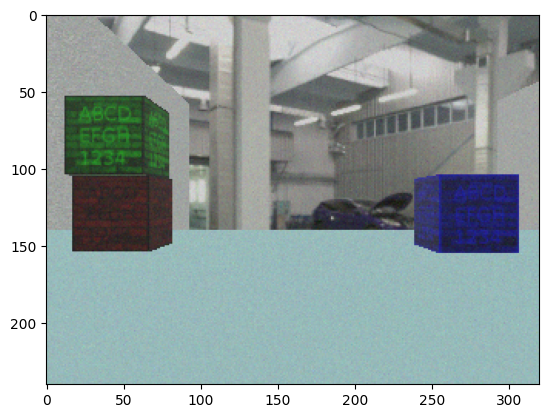

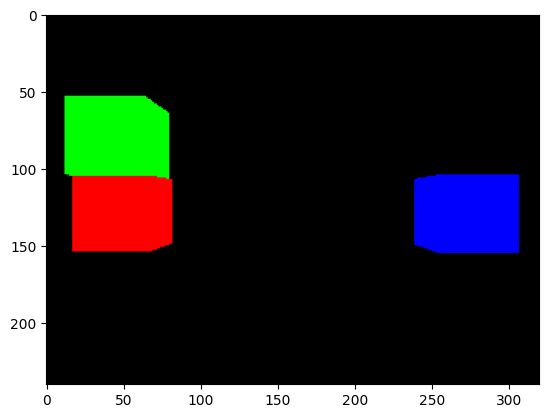

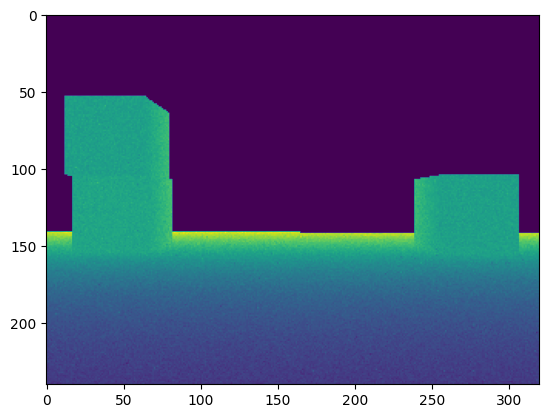

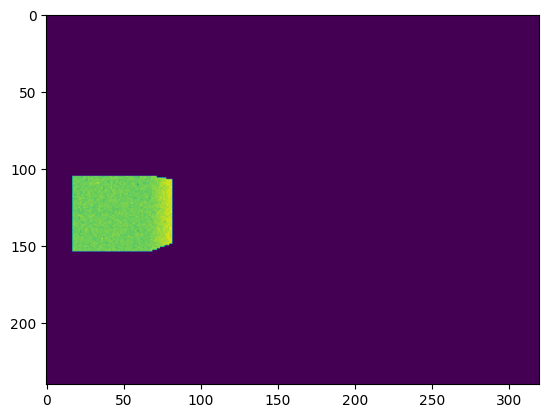

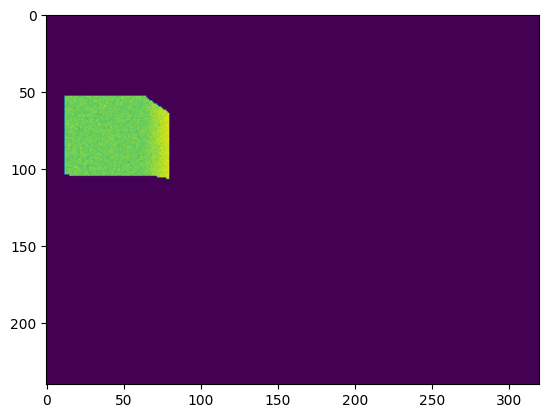

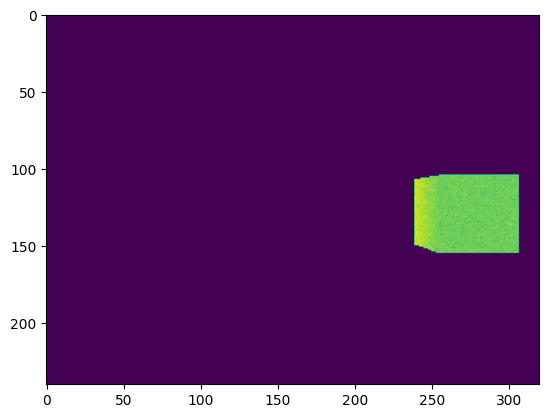

{'yellowBlock': 'redBlock', 'redBlock': 'loc-a', 'blueBlock': 'loc-c', 'loc-a': None, 'loc-b': None, 'loc-c': None}
on(yellowBlock,redBlock)
clear(yellowBlock)
on(redBlock,loc-a)
on(blueBlock,loc-c)
clear(blueBlock)
fixed(loc-a)
fixed(loc-b)
clear(loc-b)
fixed(loc-c)
initDict:
{'Block': ['redBlock', 'blueBlock', 'yellowBlock'], 'on': [('yellowBlock', 'redBlock'), ('redBlock', 'loc-a'), ('blueBlock', 'loc-c')], 'fixed': ['loc-a', 'loc-b', 'loc-c'], 'clear': ['yellowBlock', 'blueBlock', 'loc-b']}
Domain PDDL written to domain.pddl.
Problem PDDL written to problem.pddl.
INFO     planner time limit: None
INFO     planner memory limit: None

INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /home/dylan/.config/jupyterlab-desktop/jlab_server/bin/python3 '/home/dylan/Desktop/UR5-Interface-Linux/Final System/downward/builds/release/bin/translate/translate.py' domain.p

In [6]:
def blockOn(blockA,blockB):
    # returns true if blockA is on blockB based on rough world coordinates
    # returning false implies that block is on the table
    # CONDITIONALS MAY NEED TO CHANGE IF ACTUAL UR5 COORDINATE SYSTEM DOESN'T MATCH DRAWING (FOR INSTANCE CHECK BOUNDS IN X RATHER THAN Y)
    aX,aY,aZ = blockA.worldFrameCoords
    bX,bY,bZ = blockB.worldFrameCoords
    # CHANGE BLOCK LENGTH FOR REAL WORLD EXPERIMENTS WITH DIFFERENT SIZED BLOCK (0.1)
    blockLength = 0.2 # meters
    # Check if the distance between the centers is within 60% of the blockLength in the x-axis 
    if abs(bX-aX) <= (0.5*blockLength*1.2):
        # check if z-axis distance between the centers is within 65% of the blockLength with block a being on top of b
        if abs(bZ-aZ) <= (0.5*blockLength*1.3) and aZ > bZ:
            return True
    return False
            

def getProblemArguments(blocks):
    # returns initDict which contains values passed into init
    blockPairs = set()
    for blockA in blocks:
        for blockB in blocks:
            if blockA!=blockB:
                blockPairs.add((blockA,blockB))
    
    
    blockConnectionsBelow = {} # graph as dict mapping from block to block below it
    for blockA,blockB in blockPairs:
        if blockOn(blockA,blockB):
            blockConnectionsBelow[blockA.name] = blockB.name
    
    # add all other blocks to connections as bottom layer blocks having no children (None)
    for block in blocks:
        if block.name not in blockConnectionsBelow:
            # if a block has nothing below it
            blockConnectionsBelow[block.name] = None
        
    
    # hard code bottom blocks to have children locA for red locC for blue
    blockConnectionsBelow["redBlock"] = "loc-a"
    blockConnectionsBelow["blueBlock"] = "loc-c"
    blockConnectionsBelow["loc-a"] = None
    blockConnectionsBelow["loc-b"] = None
    blockConnectionsBelow["loc-c"] = None
    
    print(blockConnectionsBelow)

    # problemClass = blocksProblem()
    # problemClass.objects = blocksDomain.Object.create_objs(["redBlock","yellowBlock","blueBlock","loc-a","loc-b","loc-c"],prefix="")
    
    
    initDict = {} # Initially true predicates
    # Keys in initDict correspond to parameter names in the blockDomain.init() function 
    # with the value stored under the key passed into init() with the name of the key
    # assert that some objects are of type block
    # Here, keys are predicateNames and values are lists of of objects they hold for
    # This is used for interfacing with Py2PDDL and initializing the state in the problemClass
    
    predicateNames = ['Block','on','fixed','clear']
    # Each predicate initially acts on no objects []
    for predicateName in predicateNames:
        initDict[predicateName] = []
    
    initDict['Block'] = ['redBlock','blueBlock','yellowBlock']    
    
    for Object in blockConnectionsBelow:
        objectBelow = blockConnectionsBelow[Object]
        if objectBelow != None:
            print(f"on({Object},{objectBelow})")
            initDict["on"].append((Object,objectBelow))
            
        else:
            # bottom level object has objectBelow=None and is location therefore has 'fixed' property
            print(f"fixed({Object})")
            initDict["fixed"].append(Object)
            
        # check if block is the top layer block i.e not the child (below) any other blocks
        if not Object in blockConnectionsBelow.values():
            print(f"clear({Object})")
            initDict['clear'].append(Object)
    
    print(f"initDict:\n{initDict}")
    return initDict
                

def generatePDDLFiles(blocks):
    # generates domain.pddl and problem.pddl files based on the problem object and superclass which specifies domain
    initDict = getProblemArguments(blocks)
    problem = blocksProblem()
    problem.generate_domain_pddl()
    problem.generate_problem_pddl(
        init = {
            'initDict':initDict
        }
    )

def generatePDDLPlan():
    # precondition: call generatePDDLFiles prior to calling this
    # generates plan based on domain.pddl and problem.pddl using fast downward which is writtent to sas_plan file
    os.system("./downward/fast-downward.py domain.pddl problem.pddl --search 'astar(lmcut())'")
    

blocks = getBlocksFromImages([regImage,segImage,depthImage])
generatePDDLFiles(blocks)
generatePDDLPlan()

In [ ]:
def getTranslator(blocks):
    # returns a dictionary with keys equal to names of Block objects
    # values are block coordinates
    coordTranslator = {}
    for block in blocks:
        coordTranslator[block.name] = list(block.gripperFrameCoords)
    # hard code locations
    blockLength = 0.2
    # LOCS ARE CENTER OF EACH BLOCK BECAUSE THEY ARE PLACED ABOVE THEM
    coordTranslator["loc-a"] = coordTranslator["redBlock"] # center of red block
    coordTranslator["loc-a"][2] -= blockLength
    coordTranslator["loc-b"] = (np.array(coordTranslator["blueBlock"]) + np.array(coordTranslator["redBlock"]))/2
    coordTranslator["loc-b"][2] -= blockLength
    coordTranslator["loc-c"] = coordTranslator["yellowBlock"]
    coordTranslator["loc-c"][2] -= blockLength
    return coordTranslator


In [ ]:
def parsePlan(blocks):
    # precondition: call generatePDDLPlan prior to calling this
    # parses outputted plan in the sas_plan file into a sequence of coordinates to visit
    planFile = open("./sas_plan","r")
    fileText = planFile.read()
    planFile.close()
    steps = []
    coordTranslator = getTranslator(blocks)
        
    for actionLine in fileText.split("\n")[0:-2]:
        actionLine = actionLine.replace("(","")
        actionLine = actionLine.replace(")","")
        # only can parse move commands for now as number of params varies for other actions
        # compensating with fast downward converting to lowercase
        # can fix with refactor
        actionLine = actionLine.replace("block","Block")
        print(actionLine.split(" "))
        actionName, objectToMove,whereToMoveFrom,whereToMoveTo = actionLine.split(" ")
        print(f"Action: {actionName}\nobjectToMove: {objectToMove}\nUnder Object: {whereToMoveFrom}\nTo: {whereToMoveTo}")
    
        pickupCoords = coordTranslator[objectToMove]
        releaseCoords = coordTranslator[whereToMoveTo]
        # drop just above block
        blockLength = 0.2
        releaseCoords[2] -= blockLength
        print(f"Pick up {objectToMove} at {pickupCoords}, Release at {releaseCoords}\n")
        steps.append((pickupCoords,releaseCoords))
        # update object location reference
        coordTranslator[objectToMove] = releaseCoords
    return steps

steps = parsePlan(blocks)
print(steps)
'''
# display output for testing
coordTranslator = getTranslator()
for Object in coordTranslator:
     print(f"{Object}\nCam Coordinates: {coordTranslator[Object]}\n")
'''     

In [23]:
displayWorld(blocks)